In [2]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/train.csv")
df.head()

,document,summary
0,jason blake of the islanders will miss the res...,blake missing rest of season
1,the u.s. military on wednesday captured a wife...,u.s. arrests wife and daughter of saddam deput...
2,craig bellamy 's future at west ham appeared i...,west ham drops bellamy amid transfer turmoil
3,cambridge - when barack obama sought advice be...,in search for expertise harvard looms large
4,"wall street held on to steep gains on monday ,...",wall street ends a three-day losing streak


In [9]:
frac_to_keep = 0.5
df = df.sample(frac=frac_to_keep)

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
dataset= df

In [10]:
dataset=df.rename(columns={'document':'text'})
dataset.head()

,text,summary
0,results of play saturday in the davis cup euro...,egypt # ivory coast #
1,a powerful new earthquake rumbled across the r...,new quake triggers panic in haiti
2,"a half-century since his death , german scient...",after all these years einstein still austria '...
3,mexicans were thursday counting the human and ...,mexicans count cost of flu urged to spend holi...
4,cypriot president tassos papadopoulos and un s...,cypriot president un chief hold talks


In [11]:
dataset.shape

(10000, 2)

In [12]:
dataset.isnull().sum()

text       0
summary    0
dtype: int64

In [13]:
dataset.columns

Index(['text', 'summary'], dtype='object')

In [14]:
from sklearn.model_selection import train_test_split
X = dataset['text']
y = dataset['summary']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000,) (2000,) (8000,) (2000,)


In [25]:
train_df = pd.concat([X_train,y_train],axis=1, ignore_index=True)
test_df = pd.concat([X_test, y_test],axis=1, ignore_index=True)

In [26]:
train_df= train_df.rename(columns={0:'text',1:'summary'})
test_df= test_df.rename(columns={0:'text',1:'summary'})

In [16]:
import torch

In [17]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [19]:
from IPython.display import HTML, display
def progress(loss,value, max=100):
 return HTML(""" Batch loss :{loss}
      <progress
value='{value}'max='{max}',style='width: 100%'>{value}
      </progress>
             """.format(loss=loss,value=value, max=max))

In [20]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.9 MB/s eta 0:00:00


In [21]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("JulesBelveze/t5-small-headline-generator")
model = AutoModelForSeq2SeqLM.from_pretrained("JulesBelveze/t5-small-headline-generator")

In [22]:
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [18]:
batch_size=6
num_of_batches=int(len(X_train)/batch_size)

In [23]:
from transformers import Adafactor
optimizer = Adafactor(model.parameters(),lr=1e-4,
                      eps=(1e-30, 1e-3),
                      clip_threshold=1.0,
                      decay_rate=-0.8,
                      beta1=None,
                      weight_decay=1e-4,
                      relative_step=False,
                      scale_parameter=False,
                      warmup_init=False)

In [27]:
def trainfun(model, train_df, batch_size, num_of_epochs, optimizer):
    model.train()
    num_of_batches = int(len(train_df) / batch_size)
    loss_per_10_steps = []
    for epoch in range(1, num_of_epochs + 1):
        print('Running epoch: {}'.format(epoch))
        running_loss = 0
        out = display(progress(1, num_of_batches + 1), display_id=True)
        for i in range(num_of_batches):
            inputbatch = []
            labelbatch = []
            new_df = train_df[i * batch_size:i * batch_size + batch_size]
            for indx, row in new_df.iterrows():
                input = str(row['text']) + '[SEP]'
                labels = row['summary'] + '[SEP]'
                inputbatch.append(input)
                labelbatch.append(labels)
            inputbatch = tokenizer.batch_encode_plus(inputbatch, padding=True, max_length=512, return_tensors='pt')["input_ids"]
            labelbatch = tokenizer.batch_encode_plus(labelbatch, padding=True, max_length=512, return_tensors="pt")["input_ids"]
            inputbatch = inputbatch.to(dev)
            labelbatch = labelbatch.to(dev)

            optimizer.zero_grad()

            # Forward propagation
            outputs = model(input_ids=inputbatch, labels=labelbatch)
            loss = outputs.loss
            loss_num = loss.item()
            logits = outputs.logits
            running_loss += loss_num
            if i % 10 == 0:
                loss_per_10_steps.append(loss_num)
                out.update(progress(loss_num, i, num_of_batches + 1))

            # Calculating the gradients
            loss.backward()

            # Updating the parameters
            optimizer.step()

        running_loss = running_loss / int(num_of_batches)
        print('Epoch: {} , Running loss: {}'.format(epoch, running_loss))

    return model, loss_per_10_steps

model, loss_per_10_steps = trainfun(model, train_df, batch_size, 25, optimizer)

Running epoch: 1


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2624: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 , Running loss: 1.5657816818577852
Running epoch: 2


Epoch: 2 , Running loss: 1.3533791586678456
Running epoch: 3


Epoch: 3 , Running loss: 1.2688474906000622
Running epoch: 4


Epoch: 4 , Running loss: 1.2024275622283795
Running epoch: 5


Epoch: 5 , Running loss: 1.144940816832948
Running epoch: 6


Epoch: 6 , Running loss: 1.0945641245282152
Running epoch: 7


Epoch: 7 , Running loss: 1.0492497277903718
Running epoch: 8


Epoch: 8 , Running loss: 1.007838261436003
Running epoch: 9


Epoch: 9 , Running loss: 0.9739394067644804
Running epoch: 10


Epoch: 10 , Running loss: 0.9358672804610674
Running epoch: 11


Epoch: 11 , Running loss: 0.9027031239091411
Running epoch: 12


Epoch: 12 , Running loss: 0.8717002654916258
Running epoch: 13


Epoch: 13 , Running loss: 0.84186148498171
Running epoch: 14


Epoch: 14 , Running loss: 0.8113328811041144
Running epoch: 15


Epoch: 15 , Running loss: 0.7889066682842023
Running epoch: 16


Epoch: 16 , Running loss: 0.7609872673676592
Running epoch: 17


Epoch: 17 , Running loss: 0.7371773918097124
Running epoch: 18


Epoch: 18 , Running loss: 0.714470989862422
Running epoch: 19


Epoch: 19 , Running loss: 0.6930472840962335
Running epoch: 20


Epoch: 20 , Running loss: 0.6705029907637043
Running epoch: 21


Epoch: 21 , Running loss: 0.6518972986234549
Running epoch: 22


Epoch: 22 , Running loss: 0.6319795198017552
Running epoch: 23


Epoch: 23 , Running loss: 0.6106595177558339
Running epoch: 24


Epoch: 24 , Running loss: 0.5924890738341116
Running epoch: 25


Epoch: 25 , Running loss: 0.5731598515921487


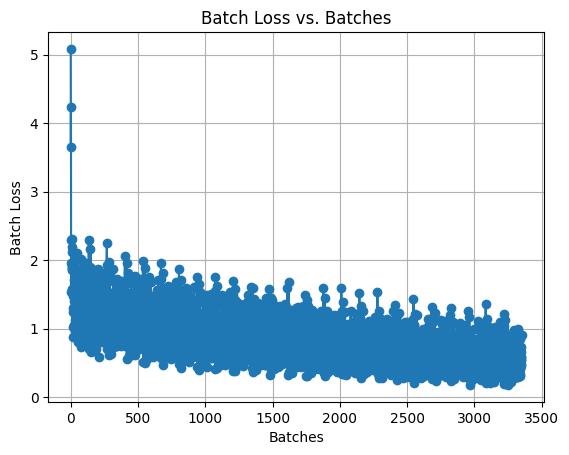

In [28]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(loss_per_10_steps) + 1), loss_per_10_steps, marker='o', linestyle='-')
plt.xlabel('Batches')
plt.ylabel('Batch Loss')
plt.title('Batch Loss vs. Batches')
plt.grid()
plt.show()

In [29]:
torch.save(model.state_dict(), "t5_model.pt")

In [72]:
def prediction(model, sent):
  model.eval()
  sent1 = str(sent) + "[SEP]"
  input_ids = tokenizer.encode(sent1, return_tensors="pt",max_length=512,padding=True)
  input_ids=input_ids.to(dev)
  outputs = model.generate(input_ids,num_beams=8, do_sample=True, min_length=10, max_length=512)
  #print(outputs)
  z=tokenizer.decode(outputs[0],skip_special_tokens=True,min_length=512)
  return(z)

In [73]:
test_df['predicted']=test_df['text'].apply(lambda x: prediction(model,x))
test_df['predicted']=test_df['predicted'].apply(lambda x: x.replace('[SEP]',''))
test_df.to_csv('res_test.csv')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2624: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [74]:
pip install sentence-transformers

In [75]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [76]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [79]:
test_df_review_summary = test_df["summary"].tolist()
test_df_predicted = test_df["predicted"].tolist()

In [80]:
similarity_scores = []
for rs_text, p_text in zip(test_df_review_summary, test_df_predicted):
    rs_embedding = model.encode(rs_text)
    p_embedding = model.encode(p_text)
    similarity = np.inner(rs_embedding, p_embedding)
    similarity_scores.append(similarity)

In [81]:
# Printing the similarity scores for each pair
for i, similarity_score in enumerate(similarity_scores):
    print(f"Similarity between 'summary {i+1}' and its 'predicted': {similarity_score:.4f}")

Similarity between 'summary 1' and its 'predicted': 0.2057
Similarity between 'summary 2' and its 'predicted': 0.5119
Similarity between 'summary 3' and its 'predicted': 0.4442
Similarity between 'summary 4' and its 'predicted': 0.8814
Similarity between 'summary 5' and its 'predicted': 0.8055
Similarity between 'summary 6' and its 'predicted': 0.4970
Similarity between 'summary 7' and its 'predicted': 0.7458
Similarity between 'summary 8' and its 'predicted': 0.8808
Similarity between 'summary 9' and its 'predicted': 0.8201
Similarity between 'summary 10' and its 'predicted': 0.6966
Similarity between 'summary 11' and its 'predicted': 0.7716
Similarity between 'summary 12' and its 'predicted': 0.8173
Similarity between 'summary 13' and its 'predicted': 0.7836
Similarity between 'summary 14' and its 'predicted': 0.2475
Similarity between 'summary 15' and its 'predicted': 0.5036
Similarity between 'summary 16' and its 'predicted': 0.6342
Similarity between 'summary 17' and its 'predicte

In [82]:
average_similarity = np.mean(similarity_scores)

#average similarity score
print(f'Average Cosine Similarity Score: {average_similarity:.4f}')

Average Cosine Similarity Score: 0.6380


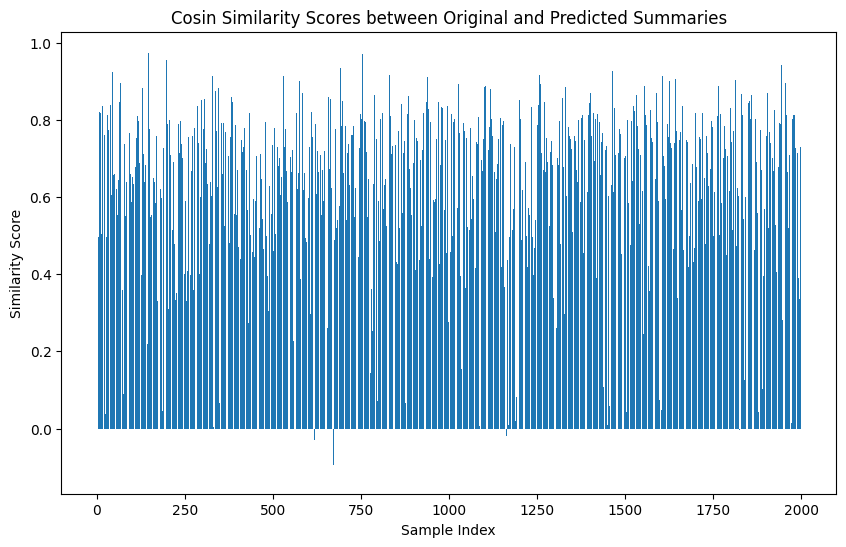

In [83]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(similarity_scores)), similarity_scores)
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Cosin Similarity Scores between Original and Predicted Summaries')
plt.show()

In [84]:
from rouge import Rouge

# Create lists of reference summaries and system-generated summaries
reference_summaries = test_df['summary'].tolist()
system_generated_summaries = test_df["predicted"].tolist()  # The generated summaries

# Initialize the Rouge object
rouge = Rouge()

# Calculate ROUGE scores
scores = rouge.get_scores(system_generated_summaries, reference_summaries, avg=True)

# Print the ROUGE scores
print(scores)

{'rouge-1': {'r': 0.4309016693274049, 'p': 0.17155044734082603, 'f': 0.2373917516486742}, 'rouge-2': {'r': 0.1463489205239206, 'p': 0.05482356713854309, 'f': 0.07691582934980887}, 'rouge-l': {'r': 0.38738549550939294, 'p': 0.15505469984897952, 'f': 0.2141677477499734}}
